### Реализация алгоритма $\Delta^*+1$

Для реализации алгоритма $\Delta^*+1$ воспользуемся следующими библиотеками Python:
* NetworkX - для представления графов, а также для генерации разных графов
* DisjointSet - реализация "Disjoint Set Union"
* collection.queue - реализация FIFO-queue
* NumPy - для генерации случайных чисел
* Matplotlib - для визуализации графов

In [1]:
import networkx as nx
from disjoint_set import DisjointSet
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_tree_over_graph(T, G=None, pos=None, title=None):
    """Plot the tree T of the graph G with Matplotlib.
    
    Parameters
    ----------
    T : tree
        A networkx graph
        
    G : graph
        A networkx graph, optional
        
    pos :  dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.

    title : string, optional
        The title for the plot
    """
    plt.figure(figsize=(12, 9)) 
    if pos is None:
        pos = nx.drawing.spring_layout(G if G is not None else T)
    if G is not None:
        nx.draw_networkx(G, pos, edge_color='grey', node_color='white',
                         style=':')
    nx.draw_networkx(T, pos, edge_color='red', node_color='red')
    if title:
        plt.title(title)
    plt.show()
    
def near_minimum_degree_spanning_tree(G, T=None, seed=None, pos=None,
    trace=False, plot_initial=False, plot_final=False, plot_all=False,
    plot_iterations=[]):
    """Near-optimal Minimum Degree Spanning Tree algoritms
    
    Parameters
    ----------
    G : graph
        A networkx graph, optional
        
    T : starting tree to iterate, optional
        A networkx graph
        If tree is absent, DFS-tree from the first vertex will be taking
        examples of possible tree generation:
        nx.dfs_tree(G, next(iter(G.nodes))).to_undirected()
        nx.bfs_tree(G, next(iter(G.nodes))).to_undirected()
        nx.minimum_spanning_tree(G, algorithm='boruvka')
        
    
    seed : int or None, optional (default=None)
        Set the random state for algorithm edge selection and for plots.

    pos : dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.

    trace : boolean, optional (default=False)
        Print information about iterations
        
    plot_initial : boolean, optional (default=False)
        Plot the initial tree
        
    plot_final : boolean, optional (default=False)
        Plot the final tree
        
    plot_all : boolean, optional (default=False)
        Plot trees after all iterations
        
    plot_iterations : list of ints, optional
        Plot trees only after specified iterations
        
    Returns
    -------
    T : near-optimal tree
    
    k : maximum degree of build tree T
    
    W : witness set of nodes (to prove T is close to optimal)
    """

    if seed is not None:
        np.random.seed(seed)
    if pos is None:
        pos = nx.drawing.spring_layout(G)

    # Шаг 1. Найдём остовное дерево T из G.
    
    if T is None:
        T = nx.dfs_tree(G, next(iter(G.nodes))).to_undirected()
    if plot_initial:
        plot_tree_over_graph(T, G, pos, f'Initial tree')
        
    # Шаг 2a. Найдём k - степень T. Вершины степени k и k - 1 как плохие
    # (поместим в множество W).
    # Для остальных вершин построим "Disjoint Set Union" F.

    iteration = 0  # номер итерации
    while True:
        iteration += 1
        # TD - DegreeView, changing authomatically with T
        TD = T.degree
        # k - максимальная степень вершин T
        k = max(d for n, d in TD)
        # W - множество плохих вершин степеней k и k - 1
        W = {n for n, d in TD if d == k or d == k - 1}
        
        if trace:
            print(f'Iteration: {iteration} k: {k}, W: {W}')
        # F - DSU для T-W
        F = DisjointSet()
        for u, v in T.edges(data=False):
            if u not in W and v not in W:
                F.union(u, v)

        # Шаг 2b. До тех пор, пока существует ребро (u, v) в G, соединяющее
        # две разные компоненты связности F и все вершины степени k помечены
        # как плохие, выполняем действия:
        # i. Найдём плохие вершины в цикле C, порожденном T вместе с (u, v),
        # и отметим их как хорошие. Для каждой такой вершины запомним (u, v),
        # при которых они стали хорошими.
        # ii. Обновим F путем объединения компонентов связности в цикле C,
        # эти вновь отмеченные вершины объединятся в единую компоненту.

        improved = False  # флаг, что была улучшена вершина степени k
        candidate = None  # индекс улучшенной вершины
        unblock = {}  # {w:(u,v)} ребра (u,v), улучшающие вершину w
        
        E = deque([(u, v) for u, v in G.edges(data=False)
                   if u not in W and v not in W and not F.connected(u, v)])
        # E - начальный список ребёр между компонентами связности,
        #     в который могут добаляться новые рёбра по мере того,
        #     как вершины помечаются хорошими
        while E:
            u, v = E.popleft()

            if F.connected(u, v):  # u и v уже в одной комноненте связности
                continue

            C = nx.shortest_path(T, u, v)
            # С - цикл, образованный добавлением ребра (u,v) к дереву T

            candidates = [w for w in C if TD[w] == k]  # вершины степени k в C
            if candidates:
                # среди вершин степени k в цикле C случайно выбираем одну
                candidate = candidates[np.random.randint(len(candidates))] 
                # запоминаем улучшающее ребро (u,v) для вершины candidate
                unblock[candidate] = (u, v)
                break

            for w in C:
                if TD[w] == k - 1 and w in W:  # плохая вершина степени k-1 в C
                    W.remove(w)  # помечаем вершину степени k-1, как хорошую
                    # дополнительные улучшающие ребра
                    E.extend([(u, v) for u, v in G.edges(w)
                              if u not in W and v not in W
                              and not F.connected(u, v)])
                    # запоминаем улучшающее ребро (u,v) для вершины w
                    unblock[w] = (u, v)  
                    F.union(u, w)  # связываем компоненты u, v, w
                    F.union(v, w)
                            
        # iii. Если есть вершина w (candidate) степени k, отмеченная
        # как хорошая, выполняем функцию улучшения для w.

        if candidate:
            Q = deque([candidate])  # FIFO очередь вершин для улучшений
            while Q:
                w = Q.popleft()
                u, v = unblock[w]
                С = nx.shortest_path(T, u, v)
                i = С.index(w)
                # случайно выбираем одно из двух рёбер вершины w цикла C
                # для удаления
                rnd = np.random.randint(2)  
                edge_to_remove = (С[i - 1 + rnd], С[i + rnd])
                T.add_edge(u, v)
                T.remove_edge(edge_to_remove[0], edge_to_remove[1])
                if trace:
                    print(f'  replace the edge {edge_to_remove[0]}-'
                          f'{edge_to_remove[1]} with an edge {u}-{v}')

                if TD[u] == k:  # если вершина u стала блокирующей
                    Q.append(u)
                if TD[v] == k:  # если вершина v стала блокирующей
                    Q.append(v)

            if plot_all or iteration in plot_iterations:
                plot_tree_over_graph(T, G, pos,
                                     f'Iteration {iteration}, improved tree')

        # Шаг 2c. Если в предыдущем пункте не было выполнено действие (iii),
        # то в дереве не осталось вершин степени k, которые можно улучшить.
        # Останавливаем работу алгоритма.
        
        else:
            break

    # Шаг 3. Выводим конечное дерево T, его степень k и свидетельствующее
    # множество W, состоящий из всех вершин помеченных как плохие.
    
    if trace:
        print(f'Algorithm finished with k: {k}, W: {W}')
    if plot_final:
        plot_tree_over_graph(T, G, pos, f'Final tree')
    return T, k, W

## Пример, когда алгоритм не находит минимальную степень

Для приведённого графа, очевидно, существует гамильтонов путь, однако алгоритм не может совершить ни одной итерации и возвращает дерево со степенью $k=3$. 

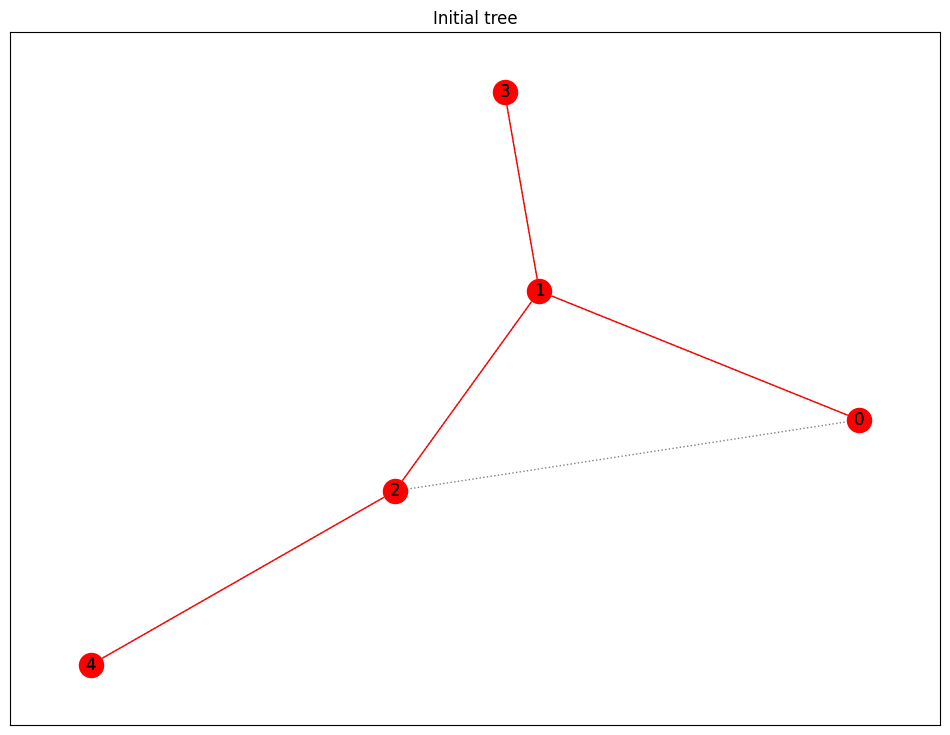

Iteration: 1 k: 3, W: {1, 2}
Algorithm finished with k: 3, W: {1, 2}


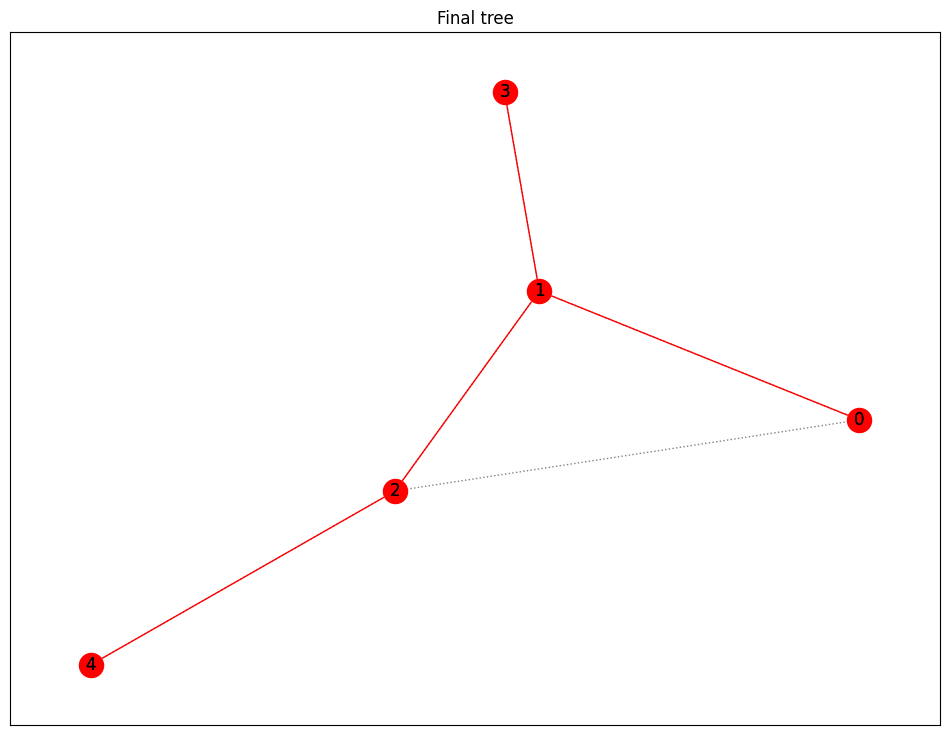

In [3]:
G = nx.bull_graph()
T, k, W = near_minimum_degree_spanning_tree(
    G, seed=10, trace=True, plot_initial=True, plot_final=True)

## Пример сложной итерации

Приведём пример графа, когда на одной итерации происходит замена нескольких ребер. Перед первой итерацией множетсво плохих вершит включает {4, 7, 12, 14}. Первые три вершины имеют степень $k-1=4$, последняя степень $k=5$. Сначала мы находим, что ребро 1-2 создаёт цикл через вершину 4 и мы помечает её хорошей. Ребро 4-5 делает вершину 7 хорошей, а ребро 9-10 вершину 12 хорошей. Наконец, ребро 7-12 проходит через вершину 14 степени $k=5$. Заменим ребро 8-14 ребром 7-12 мы получает вершины 7 и 12 степени $k=5$, продолжая процесс улучшения, мы последовательно заменим 4 ребра.

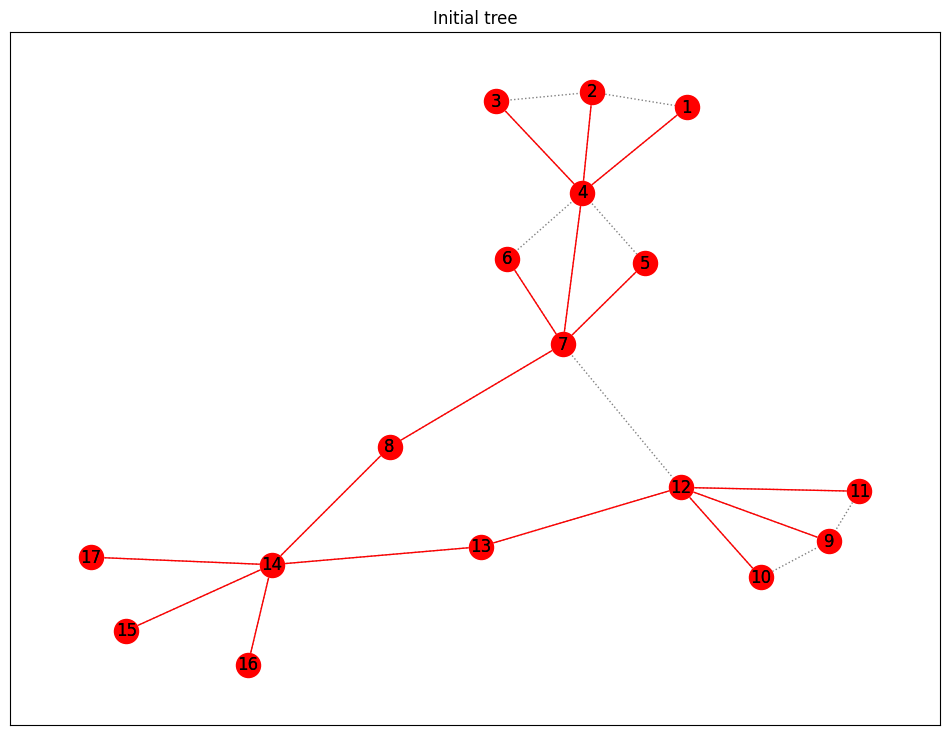

Iteration: 1 k: 5, W: {4, 12, 14, 7}
  replace the edge 8-14 with an edge 7-12
  replace the edge 7-5 with an edge 4-5
  replace the edge 9-12 with an edge 9-10
  replace the edge 1-4 with an edge 1-2


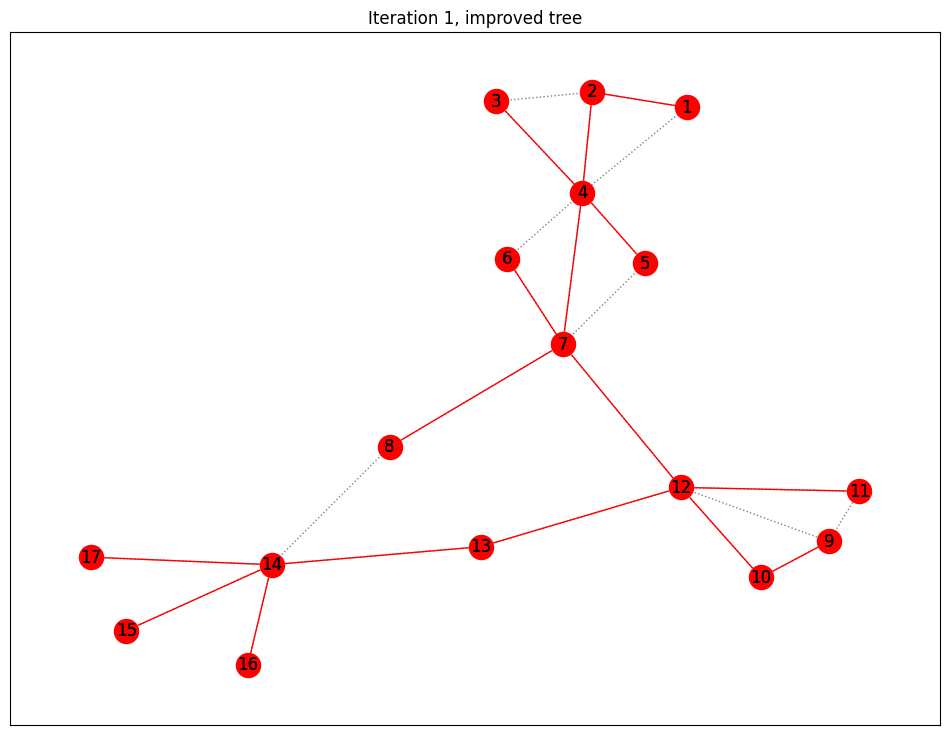

Iteration: 2 k: 4, W: {4, 12, 14, 7}
  replace the edge 2-4 with an edge 2-3


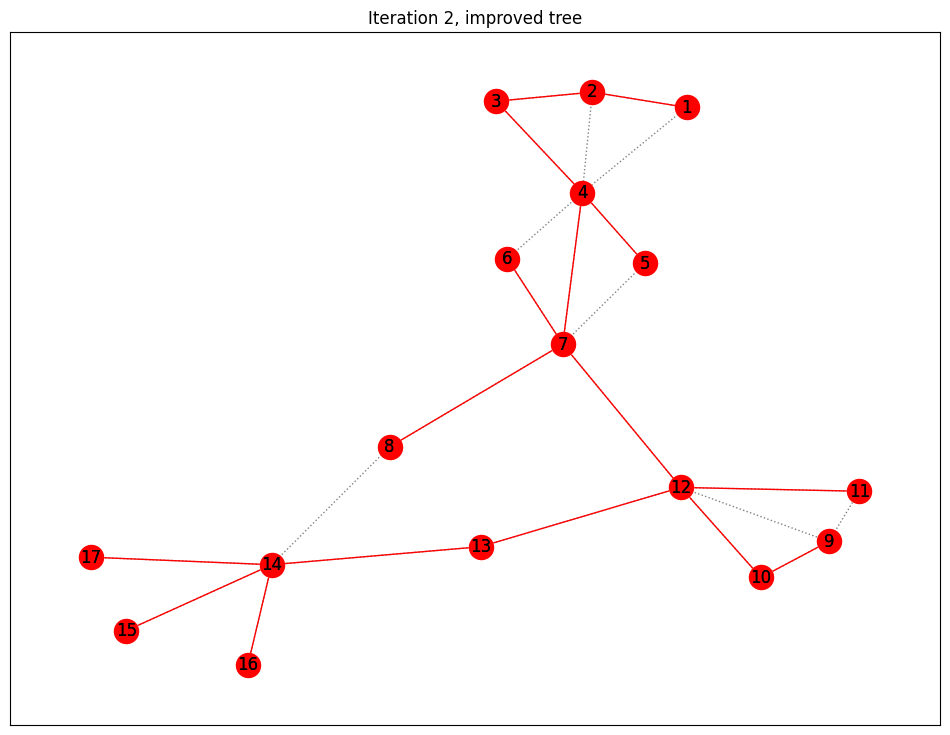

Iteration: 3 k: 4, W: {4, 12, 14, 7}
  replace the edge 12-11 with an edge 9-11


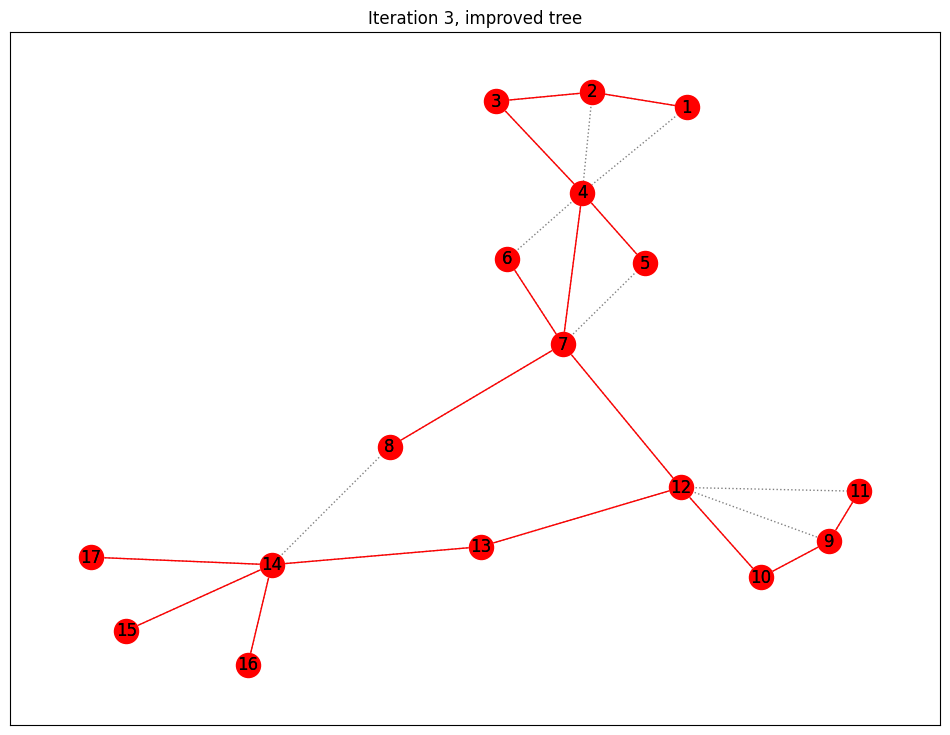

Iteration: 4 k: 4, W: {4, 12, 14, 7}
Algorithm finished with k: 4, W: {4, 12, 14, 7}


In [4]:
G_adjdata = ["1 2 4", "2 3 4", "3 4", "4 5 6 7", "5 7", "6 7", "7 8 12",
             "8 14", "9 10 11 12", "10 12", "11 12", "12 13", "13 14",
             "14 15 16 17"]
T_adjdata = ["1 4", "2 4", "3 4", "4 7", "5 7", "6 7", "7 8", "8 14",
             "9 12", "10 12", "11 12", "12 13", "13 14", "14 15 16 17"]
G = nx.parse_adjlist(G_adjdata, nodetype=int)
T = nx.parse_adjlist(T_adjdata, nodetype=int)
np.random.seed(42)
pos = nx.drawing.spring_layout(G)
T, k, W = near_minimum_degree_spanning_tree(
    G, T=T, seed=42, pos=pos, trace=True,
    plot_initial=True, plot_all=True)

## Граф Дороговцева, Гольцева и Мендеса

Это иерхаически конструируемый граф, когда на каждом ребре строится треугольник. Он интересен тем, что при больших степенях имеет большую степень для "остовое дерево минимальной степени".

Приведём расчёты для $n=3$, $n=4$ и $n=6$.

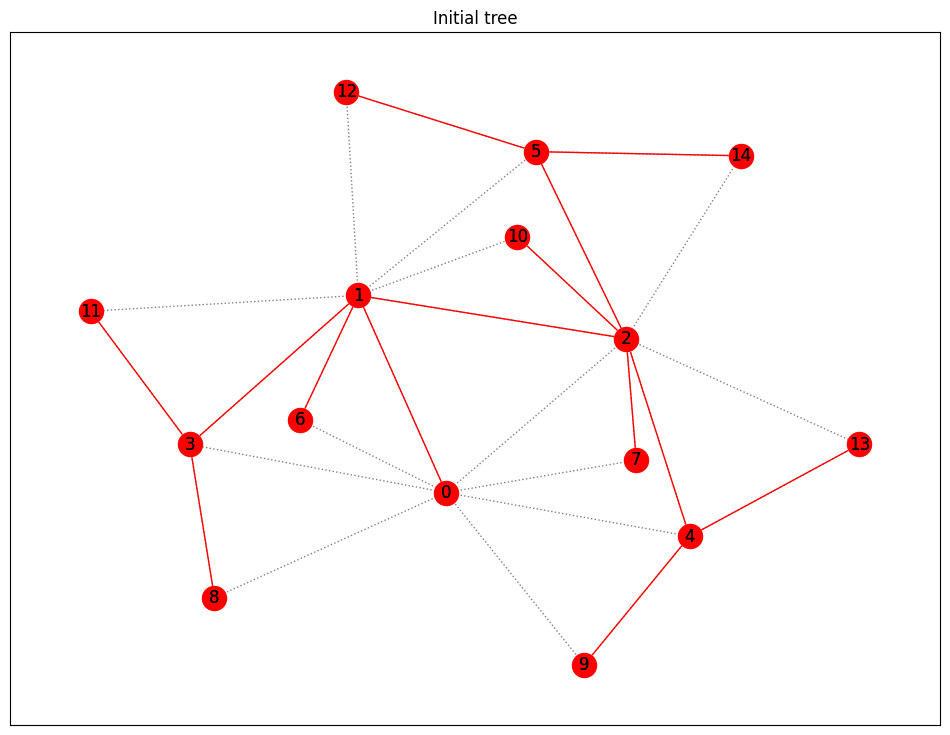

Iteration: 1 k: 5, W: {1, 2}
  replace the edge 2-4 with an edge 0-4
Iteration: 2 k: 4, W: {1, 2, 3, 4, 5}
  replace the edge 0-1 with an edge 0-6
Iteration: 3 k: 4, W: {1, 2, 3, 4, 5}
  replace the edge 1-2 with an edge 0-7
Iteration: 4 k: 3, W: {0, 1, 2, 3, 4, 5, 6, 7}
Algorithm finished with k: 3, W: {0, 1, 2, 3, 4, 5, 6, 7}


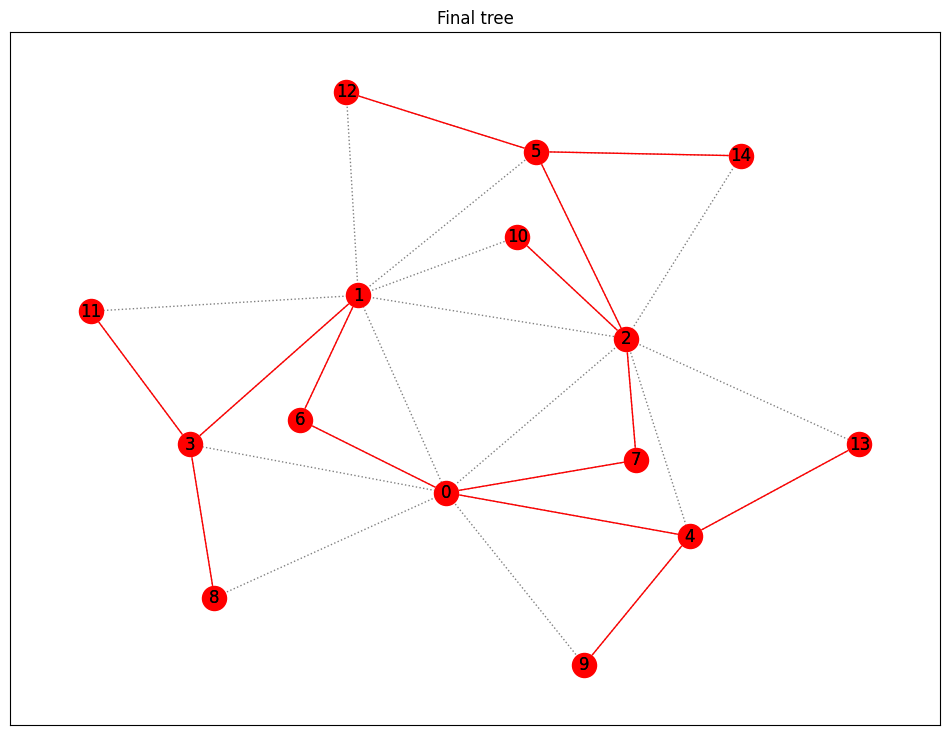

In [5]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)
T, k, W = near_minimum_degree_spanning_tree(
    G, seed=10, trace=True, plot_initial=True, plot_final=True)

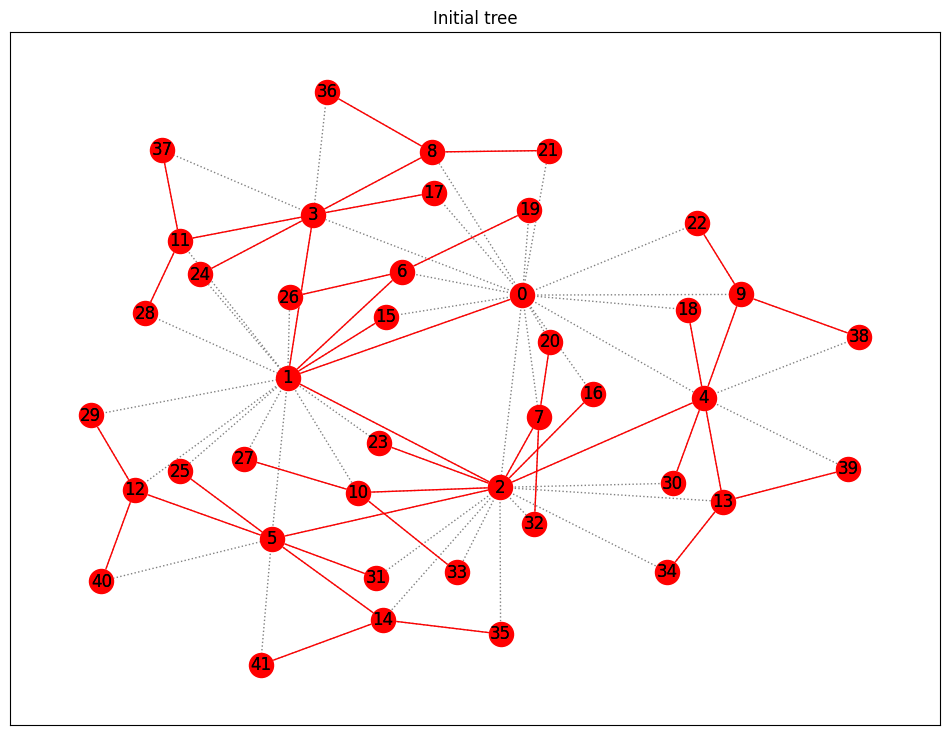

Iteration: 1 k: 7, W: {2}
  replace the edge 2-4 with an edge 0-4
Iteration: 2 k: 6, W: {1, 2, 3, 4, 5}
  replace the edge 1-2 with an edge 0-7
Iteration: 3 k: 5, W: {1, 2, 3, 4, 5, 7}
  replace the edge 3-8 with an edge 0-8
Iteration: 4 k: 5, W: {0, 1, 2, 3, 4, 5, 7}
Algorithm finished with k: 5, W: {0, 1, 2, 3, 4, 5, 7}


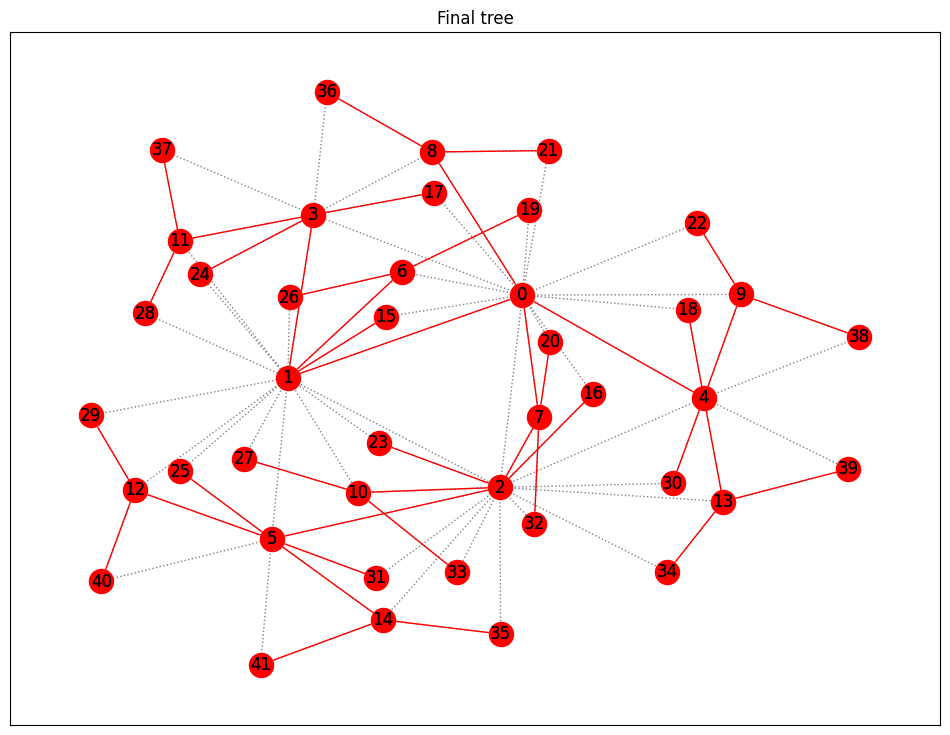

In [6]:
G = nx.dorogovtsev_goltsev_mendes_graph(4)
T, k, W = near_minimum_degree_spanning_tree(
    G, seed=0, trace=True, plot_initial=True, plot_final=True)

In [7]:
G = nx.dorogovtsev_goltsev_mendes_graph(6)
T, k, W = near_minimum_degree_spanning_tree(
    G, seed=10, trace=True)

Iteration: 1 k: 11, W: {2}
  replace the edge 2-4 with an edge 0-4
Iteration: 2 k: 10, W: {2, 3, 4, 5}
  replace the edge 2-7 with an edge 0-7
Iteration: 3 k: 9, W: {2, 3, 4, 5}
  replace the edge 1-3 with an edge 0-8
Iteration: 4 k: 9, W: {2, 3, 4, 5, 8}
  replace the edge 0-4 with an edge 0-9
Iteration: 5 k: 9, W: {2, 3, 4, 5, 8, 9}
  replace the edge 2-16 with an edge 0-16
Iteration: 6 k: 9, W: {2, 3, 4, 5, 8, 9}
  replace the edge 5-12 with an edge 1-12
Iteration: 7 k: 8, W: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
  replace the edge 8-3 with an edge 0-17
Iteration: 8 k: 8, W: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
  replace the edge 9-4 with an edge 0-18
Iteration: 9 k: 8, W: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Algorithm finished with k: 8, W: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
